# Using Amazon SageMaker to Clone Driving Behavior
## Introduction
This Notebook is a prototype for a Level 300-400 re:Invent 2018 Hackathon where participants will perform the following:

1. Drive a vehicle on a mock track using a [Self-Driving Car Simulator](https://github.com/udacity/self-driving-car-sim) to capture the vehicle's telemetry.
2. Create a Machine Learning (ML) Pipeline, using the telemetry data, to clone the driving behavior as part of a Deep Learning model.
3. Deploy the behavioral cloning model to a production SageMaker Inference Endpoint.
4. Use the Endpoint to autonomously drive the vehicle around a second mock track.

In [1]:
# Suggested Libraries for conda_mxnet
import warnings
import zipfile
import os
#from tqdm import tqdm_notebook
import boto3
import sagemaker
import cv2
import requests
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import *
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizers import Adam
#from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from IPython.display import display
from sklearn.model_selection import train_test_split
warnings.simplefilter('ignore')
%matplotlib inline

#from threading import Thread
import threading

# Configure SageMaker
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


---
## Data Exploration
### Sample Dataset
[sample dataset](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip)

In [2]:
# Download and extract Sample Data
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip'
r = requests.get(url)
with open("data.zip", "wb") as file:
    file.write(r.content)
with zipfile.ZipFile("data.zip") as zf:
    zf.extractall()

In [3]:
data_df = pd.read_csv('./data/driving_log.csv')
data_df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


### Data Exploration

In [4]:
# Data Overview
print("Dataset Shape: {}".format(data_df.shape))
print(data_df.describe())

Dataset Shape: (8036, 7)
          steering     throttle        brake        speed
count  8036.000000  8036.000000  8036.000000  8036.000000
mean      0.004070     0.869660     0.001970    28.169839
std       0.128840     0.301326     0.036565     6.149327
min      -0.942695     0.000000     0.000000     0.502490
25%       0.000000     0.985533     0.000000    30.183093
50%       0.000000     0.985533     0.000000    30.186400
75%       0.000000     0.985533     0.000000    30.186640
max       1.000000     0.985533     1.000000    30.709360


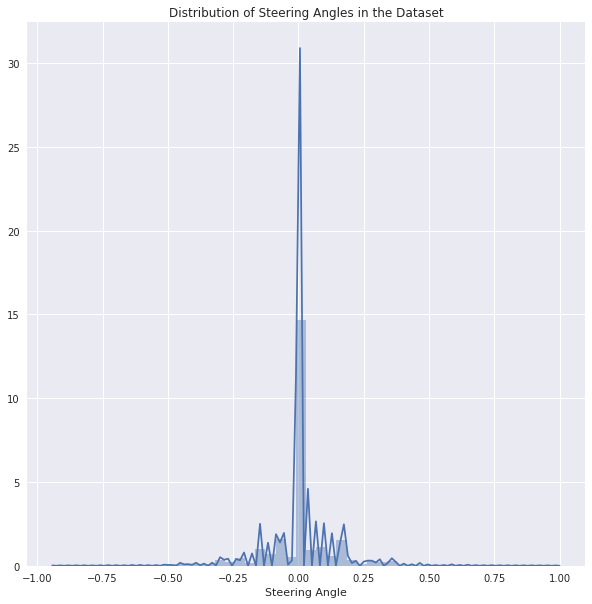

In [5]:
# Visualize the distribution of the data
sns.set(rc={'figure.figsize':(10, 10)})
fig = sns.distplot(data_df.steering)
plt.xlabel("Steering Angle")
plt.title("Distribution of Steering Angles in the Dataset")
plt.show(fig);

The Sample Dataset is skewed toward the zero steering angle and therefore more training data will need to be added during the Data Preprocessing step.

---
## Data Preprocesing
### Training and Validation Datasets
Create the Training and Vlaidation Datasets using a 90/10 split respectivley. There is no Test Dataset as the final test will be acomplished using the Simulator.

In [6]:
# Shuffle the data
data = data_df.reindex(np.random.permutation(data_df.index))
num_train = int((len(data) / 10.) * 9.)
X_train = data.iloc[:num_train]
X_valid = data.iloc[num_train:]
print("X_train No. Observations: {}".format(len(X_train)))
print("X_valid No. Pbservations: {}".format(len(X_valid)))

X_train No. Observations: 7232
X_valid No. Pbservations: 804


### Image Augementation
Generate new training data from a smaller dataset for under represented steering angles by a technique called Image Augmentation, using following 7 augmentation functions as part of the data preprocessing pipeline:

- horizontal_flip
- channel_shift
- height_shift
- width_shift
- brightness_shift
- crop_image
- resize_image

In [7]:
# Image augmentation variables
CAMERA_OFFSET = 0.25
CHANNEL_SHIFT_RANGE = 0.2
WIDTH_SHIFT_RANGE = 100
HEIGHT_SHIFT_RANGE = 40

# Processed image variables
PROCESSED_IMG_COLS = 64
PROCESSED_IMG_ROWS = 64
PROCESSED_IMG_CHANNELS = 3

# Model training variables
NB_EPOCH = 8
BATCH_SIZE = 256
DIR='data/'

# Flip images horizontally
def horizontal_flip(img, steering_angle):
    flipped_image = cv2.flip(img, 1)
    steering_angle = -1 * steering_angle
    return flipped_image, steering_angle

# Shift range of each channel
def channel_shift(img, channel_shift_range=CHANNEL_SHIFT_RANGE):
    img_channel_index = 2 # tf indexing
    channel_shifted_image = random_channel_shift(img, channel_shift_range, img_channel_index)
    return channel_shifted_image

# Shift height/width of the image by a small fraction
def height_width_shift(img, steering_angle):
    rows, cols, channels = img.shape
    
    # Translation
    tx = WIDTH_SHIFT_RANGE * np.random.uniform() - WIDTH_SHIFT_RANGE / 2
    ty = HEIGHT_SHIFT_RANGE * np.random.uniform() - HEIGHT_SHIFT_RANGE / 2
    steering_angle = steering_angle + tx / WIDTH_SHIFT_RANGE * 2 * .2
    
    transform_matrix = np.float32([[1, 0, tx],
                                   [0, 1, ty]])
    
    translated_image = cv2.warpAffine(img, transform_matrix, (cols, rows))
    return translated_image, steering_angle

# Randomly adjust the increase/decrease brightness
def brightness_shift(img, bright_value=None):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    if bright_value:
        img[:,:,2] += bright_value
    else:
        random_bright = .25 + np.random.uniform()
        img[:,:,2] = img[:,:,2] * random_bright
    
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

# Extract Region of Interest (ROI)
def crop_resize_image(img):
    shape = img.shape
    img = img[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
    img = cv2.resize(img, (PROCESSED_IMG_COLS, PROCESSED_IMG_ROWS), interpolation=cv2.INTER_AREA)    
    return img

def apply_random_transformation(img, steering_angle):
    
    transformed_image, steering_angle = height_width_shift(img, steering_angle)
    transformed_image = brightness_shift(transformed_image)
    # transformed_image = channel_shift(transformed_image) # increasing train time. not much benefit. commented
    
    if np.random.random() < 0.5:
        transformed_image, steering_angle = horizontal_flip(transformed_image, steering_angle)
            
    transformed_image = crop_resize_image(transformed_image)
    
    return transformed_image, steering_angle

### Display Image Augementation on a sing random image

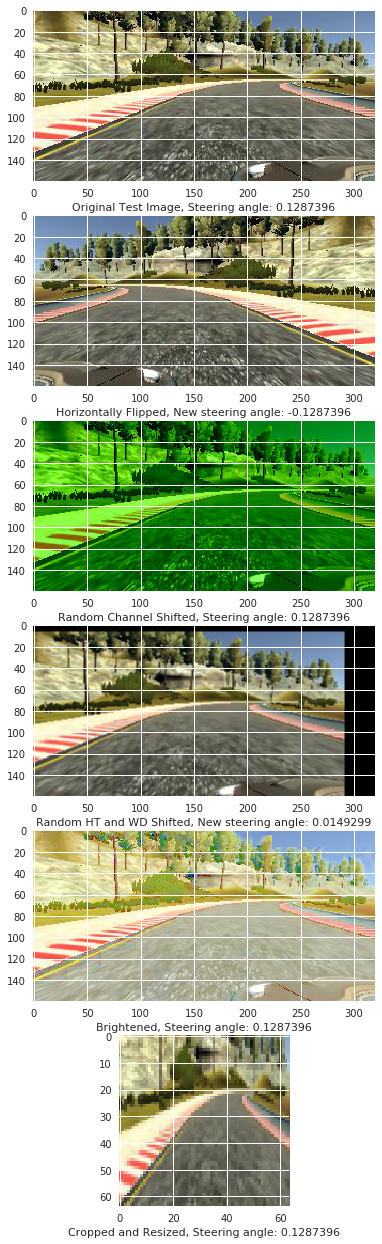

In [8]:
sample_image = load_img(DIR+str(X_train['left'][265]).split(' ')[1])
sample_image = img_to_array(sample_image)
sample_angle = X_train['steering'][265]
plt.subplots(figsize=(11, 22))

# original image
plt.subplot(611)
plt.xlabel("Original Test Image, Steering angle: " + str(sample_angle))
plt.imshow(array_to_img(sample_image))

# horizontal flip augmentation
flipped_image, new_steering_angle = horizontal_flip(sample_image, sample_angle)
plt.subplot(612)
plt.xlabel("Horizontally Flipped, New steering angle: " + str(new_steering_angle))
plt.imshow(array_to_img(flipped_image))

# channel shift augmentation
channel_shifted_image = channel_shift(sample_image, 255)
plt.subplot(613)
plt.xlabel("Random Channel Shifted, Steering angle: " + str(sample_angle))
plt.imshow(array_to_img(channel_shifted_image))

# width shift augmentation
width_shifted_image, new_steering_angle = height_width_shift(sample_image, sample_angle)
new_steering_angle = "{:.7f}".format(new_steering_angle)
plt.subplot(614)
plt.xlabel("Random HT and WD Shifted, New steering angle: " + str(new_steering_angle))
plt.imshow(array_to_img(width_shifted_image))

# brightened image
brightened_image = brightness_shift(sample_image, 255)
plt.subplot(615)
plt.xlabel("Brightened, Steering angle: " + str(sample_angle))
plt.imshow(array_to_img(brightened_image))

# crop augmentation
cropped_image = crop_resize_image(sample_image)
plt.subplot(616)
plt.xlabel("Cropped and Resized, Steering angle: " + str(sample_angle))
_ = plt.imshow(array_to_img(cropped_image))

### Generate Preprocessed Image Data

In [9]:
generated_steering_angles = []
threshold = 1

# generators in multi-threaded applications is not thread-safe. Hence below:
class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self
    
    def __next__(self):
        with self.lock:
            return self.it.__next__()
        
def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

# Load and Augment the data
def load_and_augment_image(line_data):
    i = np.random.randint(3)
    
    if (i == 0):
        path_file = line_data['left'][0].strip()
        shift_angle = CAMERA_OFFSET
    elif (i == 1):
        path_file = line_data['center'][0].strip()
        shift_angle = 0.
    elif (i == 2):
        path_file = line_data['right'][0].strip()
        shift_angle = -CAMERA_OFFSET
        
    steering_angle = line_data['steering'][0] + shift_angle
    
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, steering_angle = apply_random_transformation(img, steering_angle)
    return img, steering_angle

@threadsafe_generator
def generate_batch_data(_data, batch_size = 32):
    
    batch_images = np.zeros((batch_size, PROCESSED_IMG_ROWS, PROCESSED_IMG_COLS, PROCESSED_IMG_CHANNELS))
    batch_steering = np.zeros(batch_size)
    
    while 1:
        for batch_index in range(batch_size):
            row_index = np.random.randint(len(_data))
            line_data = _data.iloc[[row_index]].reset_index()
            
            # idea borrowed from Vivek Yadav: Sample images such that images with lower angles 
            # have lower probability of getting represented in the dataset. This alleviates 
            # any problems we may ecounter due to model having a bias towards driving straight.
            
            keep = 0
            while keep == 0:
                x, y = load_and_augment_image(line_data)
                if abs(y) < .1:
                    val = np.random.uniform()
                    if val > threshold:
                        keep = 1
                else:
                    keep = 1
            
            batch_images[batch_index] = x
            batch_steering[batch_index] = y
            generated_steering_angles.append(y)
        yield batch_images, batch_steering

#### Examples of Generated Data

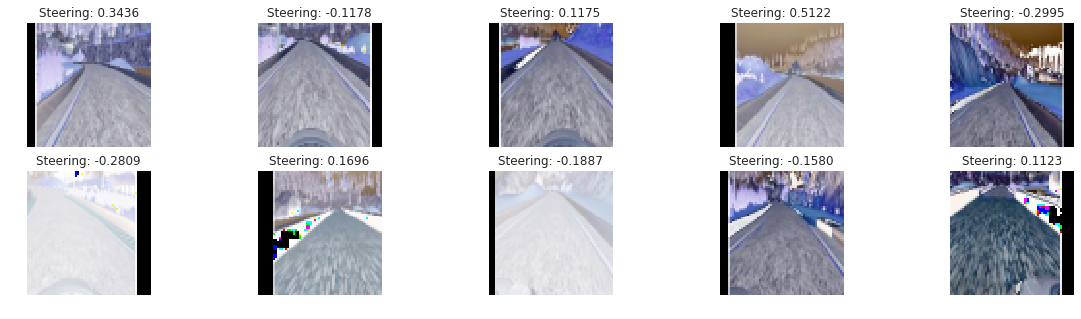

In [10]:
iterator = generate_batch_data(X_train, batch_size=10)
sample_images, sample_steerings = iterator.__next__()

plt.subplots(figsize=(20, 5))
for i, img in enumerate(sample_images):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.title("Steering: {:.4f}".format(sample_steerings[i]))
    plt.imshow(img)
plt.show()

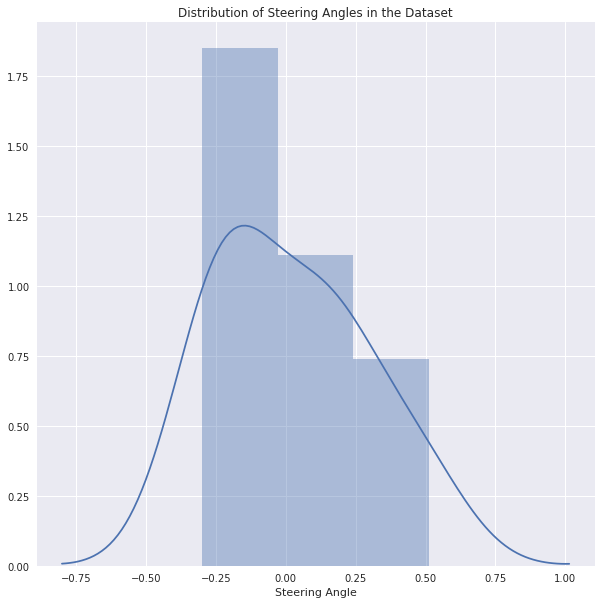

In [11]:
# Visualize the distribution of the data
fig = sns.distplot(generated_steering_angles)
plt.xlabel("Steering Angle")
plt.title("Distribution of Steering Angles in the Dataset")
plt.show(fig);

---

---
## Model Architecture and Training


In [20]:
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(PROCESSED_IMG_ROWS, PROCESSED_IMG_COLS, PROCESSED_IMG_CHANNELS)))
model.add(Conv2D(16, (8, 8), strides=(4, 4), padding="same", activation='elu'))#, name='Conv1'))
model.add(Conv2D(32, (5, 5), strides=(2, 2), padding="same", activation='elu'))#, name='Conv2'))
model.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same", activation='elu'))#, name='Conv3'))
model.add(Flatten())
model.add(Dropout(.2))
#model.add(ELU())
model.add(Dense(512, activation='elu'))#, name='FC1'))
model.add(Dropout(.5))
#model.add(ELU())
model.add(Dense(1, name='output'))
model.summary()

# compile
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='mse', metrics=[])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 16)        3088      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          12832     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)          51264     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
__________

In [21]:
class LifecycleCallback(tf.keras.callbacks.Callback):

    def on_epoch_begin(self, epoch, logs={}):
        pass

    def on_epoch_end(self, epoch, logs={}):
        global threshold
        threshold = 1 / (epoch + 1)

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_train_begin(self, logs={}):
        print('BEGIN TRAINING')
        self.losses = []

    def on_train_end(self, logs={}):
        print('END TRAINING')
        
# Calculate the correct number of samples per epoch based on batch size
def calc_samples_per_epoch(array_size, batch_size):
    num_batches = array_size / batch_size
    samples_per_epoch = math.ceil(num_batches)
    samples_per_epoch = samples_per_epoch * batch_size
    return samples_per_epoch

In [22]:
lifecycle_callback = LifecycleCallback()       

train_generator = generate_batch_data(X_train, BATCH_SIZE)
validation_generator = generate_batch_data(X_valid, BATCH_SIZE)

samples_per_epoch = calc_samples_per_epoch((len(X_train)*3), BATCH_SIZE)
nb_val_samples = calc_samples_per_epoch((len(X_valid)*3), BATCH_SIZE)


In [ ]:
history = model.fit_generator(train_generator, 
                              validation_data = validation_generator,
                              steps_per_epoch = samples_per_epoch, 
                              validation_steps = nb_val_samples,
                              epochs = NB_EPOCH, verbose=1,
                              callbacks=[lifecycle_callback])

BEGIN TRAINING
Epoch 1/8
  301/21760 [..............................] - ETA: 7:29:33 - loss: 0.0758

---
## Model Optimization and Analysis

---
## Production Deployment